<a href="https://colab.research.google.com/github/IAT-ExploringAI-2024/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

In [20]:
import random

In [21]:
dir = '/Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project'

# Data Preprocessing






### Filter lesion images to just melanoma and benign






In [6]:
lesion_metadata = pd.read_csv('data_pre/original/Skin Cancer MNIST/HAM10000_metadata.csv')

In [7]:
lesion_metadata = lesion_metadata[(lesion_metadata['dx'] == 'bkl') | (lesion_metadata['dx'] == 'mel')]
lesion_metadata

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
8834,HAM_0002552,ISIC_0033232,mel,histo,25.0,male,upper extremity
9546,HAM_0003807,ISIC_0032655,bkl,consensus,40.0,male,unknown
9630,HAM_0003807,ISIC_0033620,bkl,consensus,40.0,male,unknown
9631,HAM_0003808,ISIC_0034040,bkl,consensus,40.0,male,unknown


sex
female     Axes(0.125,0.11;0.775x0.77)
male       Axes(0.125,0.11;0.775x0.77)
unknown    Axes(0.125,0.11;0.775x0.77)
Name: age, dtype: object

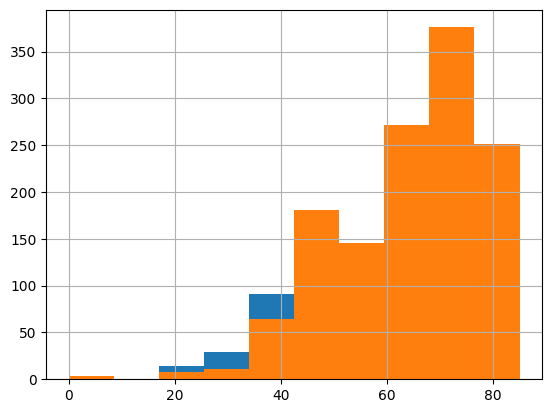

In [22]:
lesion_metadata[['age','sex']].groupby('sex').age.hist()
# plt.hist(lesion_metadata['age'])
# plt.show()

In [ ]:
lesions_keep = lesion_metadata['image_id']

In [118]:
for lesion in lesions_keep:
    shutil.move(dir + '/data/original/Skin Cancer MNIST/HAM10000_images_all/' + lesion + '.jpg', dir + '/data/original/Skin Cancer MNIST/HAM10000_images/' + lesion + '.jpg')

### Filter masks to same set





In [18]:
for lesion in lesions_keep:
    shutil.move(dir + '/data/original/masks_all/' + lesion + '_segmentation.png', dir + '/data/masks/' + lesion + '.png')

### Convert segmentation masks to polygons for YOLO





In [19]:
# Code from: https://github.com/computervisioneng/image-segmentation-yolov8/blob/main/masks_to_polygons.py
import os

import cv2


input_dir = './data/masks'
output_dir = './data/labels'

for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    # load the binary mask and get its contours
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    H, W = mask.shape
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convert the contours to polygons
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)
            polygons.append(polygon)

    # print the polygons
    with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
        for polygon in polygons:
            for p_, p in enumerate(polygon):
                if p_ == len(polygon) - 1:
                    f.write('{}\n'.format(p))
                elif p_ == 0:
                    f.write('0 {} '.format(p))
                else:
                    f.write('{} '.format(p))

        f.close()

## Creating Folders structure

Defining paths to train and test folders.

In [119]:
test_dir = '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/test_zip/test'
train_dir = '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/train_zip/train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

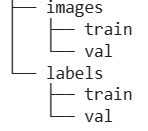


Making directories according to above struture of folders

In [20]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data')
# os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images')
# os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels')
os.makedirs('data/images/train')
os.makedirs('data/images/val')
os.makedirs('data/labels/train')
os.makedirs('data/labels/val')

In [120]:
#set the paths to labels and images directory
label_dir= dir + "/data/labels"
image_dir= dir + "/data/images"

In [60]:
from os import listdir
from os.path import isfile, join

# Read manually annotated filenames
manually_annotated_lesions = [f for f in listdir(dir + '/data_pre/new_data_images/') if isfile(join(dir + '/data_pre/new_data_images/', f))]
manually_annotated_lesions = [x[:-4] for x in manually_annotated_lesions]

In [61]:
lesions_keep = list(lesions_keep)

In [62]:
# Randomize order of filenames
randomized_labels = random.sample(lesions_keep, len(lesions_keep)) 
randomized_labels_manual = random.sample(manually_annotated_lesions, len(manually_annotated_lesions))

# Filter to exclude manually annotated files
randomized_labels = [x for x in randomized_labels if x not in randomized_labels_manual]

In [73]:
# Split into 66% Training, 33% Validation

trainCount = round((len(randomized_labels)/3) * 2)
trainCountManual = round((len(randomized_labels_manual)/3) * 2)

train = randomized_labels[0:trainCount]
trainManual = randomized_labels_manual[0:trainCountManual]

val = randomized_labels[trainCount:]
valManual = randomized_labels_manual[trainCountManual:]

In [83]:
# Move images and labels into train/val folderes

for lesion in train:
    shutil.move(dir + '/data/images/' + lesion + '.jpg', dir + '/data/images/train/' + lesion + '.jpg')
    shutil.move(dir + '/data/labels/' + lesion + '.txt', dir + '/data/labels/train/' + lesion + '.txt')

for lesion in val:
    shutil.move(dir + '/data/images/' + lesion + '.jpg', dir + '/data/images/val/' + lesion + '.jpg')
    shutil.move(dir + '/data/labels/' + lesion + '.txt', dir + '/data/labels/val/' + lesion + '.txt')

for lesion in trainManual:
    shutil.move(dir + '/data/images/' + lesion + '.jpg', dir + '/data/images/train/' + lesion + '.jpg')
    shutil.move(dir + '/data/labels/' + lesion + '.txt', dir + '/data/labels/train/' + lesion + '.txt')

for lesion in valManual:
    shutil.move(dir + '/data/images/' + lesion + '.jpg', dir + '/data/images/val/' + lesion + '.jpg')
    shutil.move(dir + '/data/labels/' + lesion + '.txt', dir + '/data/labels/val/' + lesion + '.txt')



Copy XML files and jpg files from the train folder to the folders created.

Visualizing somme pictures from the dataset

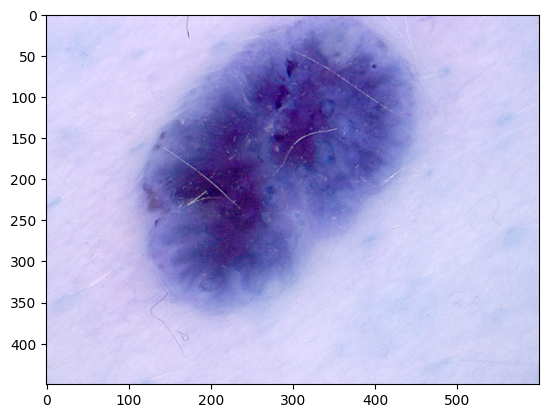

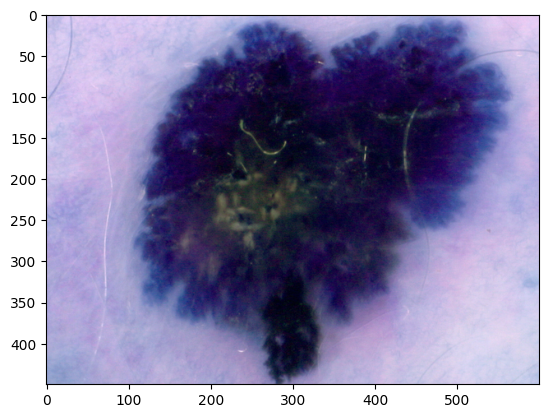

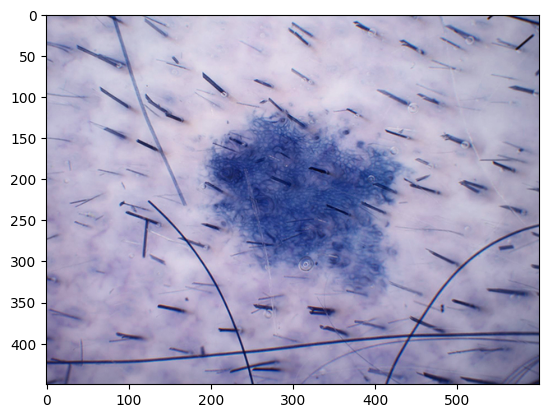

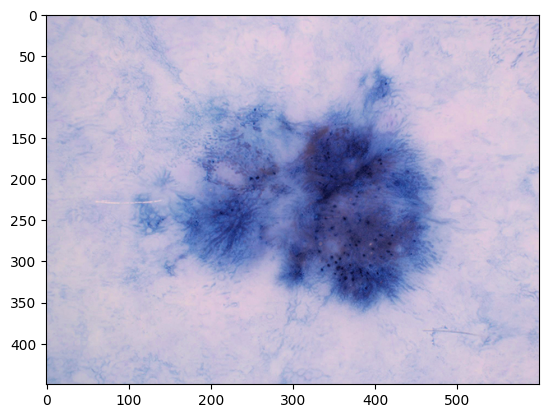

In [162]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()
    # print(os.path.join(image_dir,"train", image))
    if idx == 3:
        break

# Custom object detection using YOLO

First install and import

In [4]:
# %pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.27 🚀 Python-3.12.1 torch-2.2.1 CPU (Apple M2 Pro)
Setup complete ✅ (12 CPUs, 16.0 GB RAM, 270.6/460.4 GB disk)


In [5]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [174]:
model = YOLO('yolov8n-seg.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [175]:
model

YOLO(
  (model): SegmentationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_runnin

In [7]:
%%writefile config.yaml
path: /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data
train: /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/images/train
#test: (test dataset folder path)
val: /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/images/val

# Classes
nc: 1 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names: ['lesion']

# 50/50 iterations complete ✅ (9889.90s)
# Results saved to runs/segment/tune2
# Best fitness=1.40885 observed at iteration 39
# Best fitness metrics are {'metrics/precision(B)': 0.95699, 'metrics/recall(B)': 0.83981, 'metrics/mAP50(B)': 0.97021, 'metrics/mAP50-95(B)': 0.67865, 'metrics/precision(M)': 0.93508, 'metrics/recall(M)': 0.81543, 'metrics/mAP50(M)': 0.95193, 'metrics/mAP50-95(M)': 0.67317, 'val/box_loss': 0.96252, 'val/seg_loss': 2.166, 'val/cls_loss': 0.83494, 'val/dfl_loss': 2.63903, 'fitness': 1.40885}
# Best fitness model is runs/segment/train47
# Best fitness hyperparameters are printed below.

# lr0: 0.00781
# lrf: 0.01088
# momentum: 0.90451
# weight_decay: 0.00053
# warmup_epochs: 2.90162
# warmup_momentum: 0.75022
# box: 6.42295
# cls: 0.59322
# dfl: 2.44856
# hsv_h: 0.02027
# hsv_s: 0.88119
# hsv_v: 0.25792
# degrees: 0.0
# translate: 0.07314
# scale: 0.47864
# shear: 0.0
# perspective: 0.0
# flipud: 0.0
# fliplr: 0.47286
# mosaic: 1.0
# mixup: 0.0
# copy_paste: 0.0

Overwriting config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [51]:
model.tune(data='config.yaml', fraction=0.068, epochs=5, batch=8, iterations=50, optimizer='AdamW', plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs/segment/tune4'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/50 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Ultralytics YOLOv8.1.27 🚀 Python-3.12.1 torch-2.2.1 CPU (Apple M2 Pro)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=config.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=608, save=False, save_period=-1, cache=False, device=None, workers=0, project=None, name=train6442, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=

train: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/val.cache... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]


TensorBoard: model graph visualization added ✅
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to runs/segment/train6442
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.296       3.93      2.357      1.639         11        608: 100%|██████████| 7/7 [00:49<00:00,  7.07s/it]
  0%|          | 0/7 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.321       2.27      1.817      1.557         10        608: 100%|██████████| 7/7 [00:50<00:00,  7.23s/it]
  0%|          | 0/7 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.489      2.521      1.883       1.73          9        608: 100%|██████████| 7/7 [00:49<00:00,  7.11s/it]
  0%|          | 0/7 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G       1.36      2.292      1.777      1.623         10        608: 100%|██████████| 7/7 [00:50<00:00,  7.26s/it]
  0%|          | 0/7 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.281      2.066      1.635      1.562          7        608: 100%|██████████| 7/7 [00:50<00:00,  7.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.99s/it]


                   all         53         53      0.454      0.534      0.453      0.189      0.486      0.572      0.486      0.201

5 epochs completed in 0.073 hours.
Optimizer stripped from runs/segment/train6442/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train6442/weights/best.pt, 6.8MB

Validating runs/segment/train6442/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.12.1 torch-2.2.1 CPU (Apple M2 Pro)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.86s/it]


                   all         53         53      0.453      0.517       0.45       0.19      0.489      0.579      0.485        0.2
Speed: 0.7ms preprocess, 162.8ms inference, 0.0ms loss, 1.9ms postprocess per image
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved runs/segment/tune4/tune_scatter_plots.png
Saved runs/segment/tune4/tune_fitness.png

Tuner: 1/50 iterations complete ✅ (281.12s)
Tuner: Results saved to runs/segment/tune4
Tuner: Best fitness=0.4454 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.45429, 'metrics/recall(B)': 0.5341, 'metrics/mAP50(B)': 0.45334, 'metrics/mAP50-95(B)': 0.18918, 'metrics/precision(M)': 0.48639, 'metrics/recall(M)': 0.57184, 'metrics/mAP50(M)': 0.48594, 'metrics/mAP50-95(M)': 0.20134, 'val/box_loss': 1.86159, 'val/seg_loss': 4.04078, 'val/cls_loss': 2.93206, 'val/dfl_loss': 3.06125, 'fitness': 0.4454}
Tuner: Best fitness model is runs/segment/train6442
Tuner: Best fitness hyperparameters are printe

train: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/train.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
val: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/val.cache... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]


TensorBoard: model graph visualization added ✅
Image sizes 608 train, 608 val
Using 0 dataloader workers
Logging results to runs/segment/train6443
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.411       4.82      2.849      1.693         39        608:  57%|█████▋    | 4/7 [00:34<00:25,  8.53s/it]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ultralytics/cfg/__init__.py", line 568, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ultralytics/engine/model.py", line 655, in train
    self.trainer.train()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ultralytics/engine/trainer.py", line 213, in train
    self._do_train(world_size)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ultralytics/engine/tr

KeyboardInterrupt: 

In [176]:
# model.train(data="config.yaml",epochs=5, imgsz=600, fraction=0.14, lr0 = 0.00781, lrf = 0.01088, momentum = 0.90451, weight_decay = 0.00053, warmup_epochs = 2.90162, warmup_momentum = 0.75022, box = 6.42295, cls = 0.59322, dfl = 2.44856, hsv_h = 0.02027, hsv_s = 0.88119, hsv_v = 0.25792, degrees = 0.0, translate = 0.07314, scale = 0.47864, shear = 0.0, perspective = 0.0, flipud = 0.0, fliplr = 0.47286, mosaic = 1.0, mixup = 0.0, copy_paste = 0.0)
# model.train(data="config.yaml",epochs=10, imgsz=640, fraction=0.14)
model.train(data="config.yaml",epochs=10, batch=8, patience=5, imgsz=640, fraction=0.068)

Ultralytics YOLOv8.1.27 🚀 Python-3.12.1 torch-2.2.1 CPU (Apple M2 Pro)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=config.yaml, epochs=10, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train69, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.05, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

train: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/train.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<
val: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?

Plotting labels to runs/segment/train69/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train69
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.52      4.333      3.539      2.063          2        640: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.36s/it]

                   all        100        100    0.00327       0.98      0.563      0.331    0.00313       0.94      0.531      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.205      2.418      2.665      1.849          2        640: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.32s/it]

                   all        100        100    0.00333          1      0.563      0.293     0.0033       0.99       0.47       0.27

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       3/10         0G      1.133      2.076      2.394      1.808          2        640: 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.34s/it]

                   all        100        100    0.00333          1      0.655      0.325    0.00323       0.97       0.55      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.322      2.057      2.366      1.828          2        640: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.32s/it]

                   all        100        100    0.00327       0.98      0.665      0.351     0.0033       0.99      0.693      0.357

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       5/10         0G      1.227      2.075      2.269      1.779          2        640: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

                   all        100        100      0.937       0.15      0.668      0.371      0.937       0.15      0.715      0.436

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size



       6/10         0G      1.301      2.122      2.118      1.832          2        640: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.35s/it]

                   all        100        100      0.885       0.51       0.74      0.453      0.885       0.51      0.724       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.097      1.779      1.946      1.667          2        640: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.40s/it]

                   all        100        100      0.918      0.559      0.843      0.505      0.921       0.55      0.827      0.528



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.177      1.817      2.216        1.7          2        640: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.32s/it]

                   all        100        100      0.933      0.701      0.875      0.513      0.932      0.687      0.867      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.009      1.662        1.9      1.503          2        640: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.39s/it]

                   all        100        100      0.873      0.756      0.874      0.554      0.884      0.764       0.87      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.078      1.722      1.868      1.607          2        640: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.38s/it]

                   all        100        100      0.887       0.81      0.894      0.568      0.893      0.833      0.893      0.556

10 epochs completed in 0.119 hours.


Optimizer stripped from runs/segment/train69/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train69/weights/best.pt, 6.8MB

Validating runs/segment/train69/weights/best.pt...
Ultralytics YOLOv8.1.27 🚀 Python-3.12.1 torch-2.2.1 CPU (Apple M2 Pro)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:22<00:00,  3.22s/it]


                   all        100        100       0.89      0.807      0.893      0.568        0.9       0.83      0.892      0.558
Speed: 0.9ms preprocess, 202.1ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/segment/train69


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x32e142180>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [52]:
model = YOLO('runs/segment/tune2/weights/best.pt')

In [177]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
# metrics.box.map    # map50-95
metrics.box.map50  # map50
# metrics.box.map75  # map75
# metrics.box.maps   # a list contains map50-95 of each category
# metrics.box.mp    # P
# metrics.box.mr    # R

Ultralytics YOLOv8.1.27 🚀 Python-3.12.1 torch-2.2.1 CPU (Apple M2 Pro)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /Users/hliaqat/workspace/PhD/Courses/Spring 2024/IAT 885/assignments/cv-project/Computer-Vision-Project/data/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]


                   all        100        100       0.89      0.807      0.893      0.568        0.9       0.83      0.892      0.558
Speed: 0.5ms preprocess, 55.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/segment/train692


0.8931072187303217

In [24]:
metrics.box.map50

Showing confusion matrix, that is already stored in detect/train folder

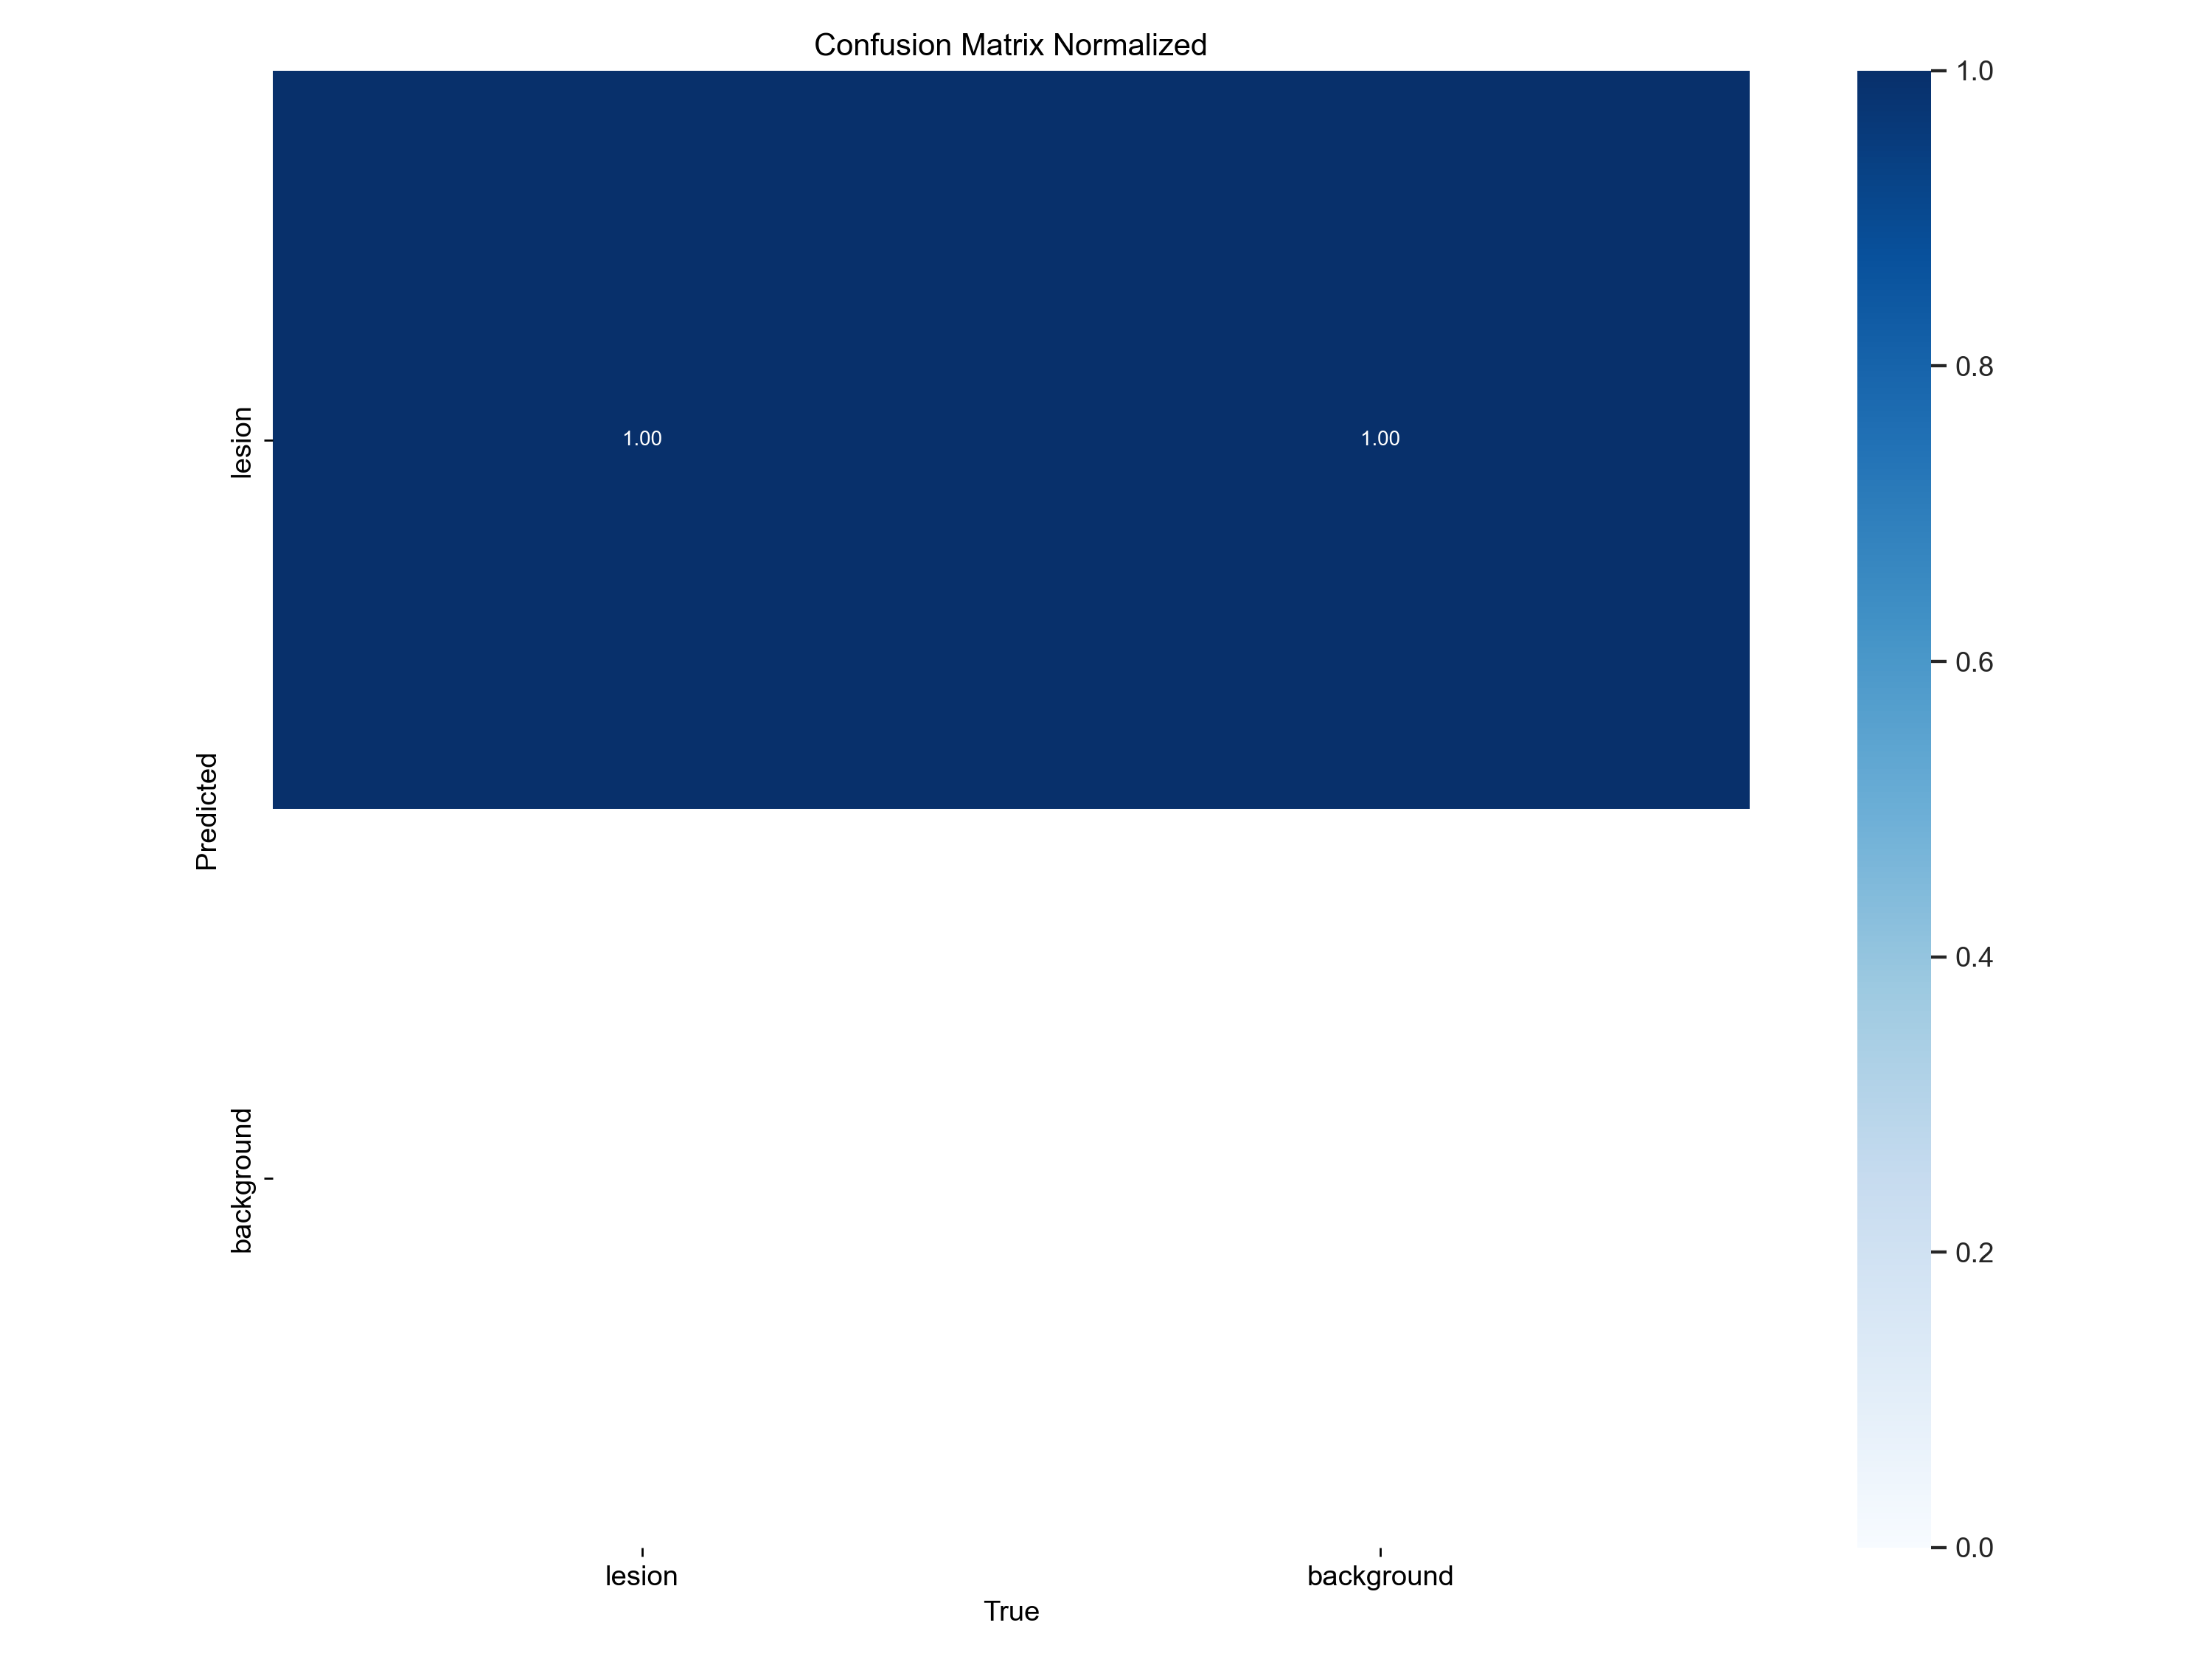

In [128]:
%matplotlib inline
from PIL import Image

Image.open('runs/segment/train26322/confusion_matrix_normalized.png')

## Prediction

In [ ]:
# Create segmentation masks on test data
# Code from: https://github.com/computervisioneng/image-segmentation-yolov8/blob/main/predict.py

from ultralytics import YOLO

import cv2

In [183]:
# model_path = 'runs/segment/train67/weights/best.pt'
# model = YOLO(model_path)

test_set = os.listdir(dir + '/data/test/')
# test_set.remove(".DS_Store")

# Read through each image in test set and creatte seg mask
for image_path in test_set:
    print(image_path)
    img = cv2.imread(dir + '/data/test/' + image_path)
    H, W, _ = img.shape
    
    results = model(img)
    
    for result in results:
            try:
                for j, mask in enumerate(result.masks.data):
                    
                    mask = mask.numpy() * 255
            
                    mask = cv2.resize(mask, (W, H))
            
                    cv2.imwrite('data/predicted_masks_tuned/' + image_path, mask)
            except:
                continue
        

ISIC_0028965.jpg

0: 480x640 1 lesion, 67.9ms
Speed: 4.0ms preprocess, 67.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
ISIC_0033612.jpg

0: 480x640 1 lesion, 68.8ms
Speed: 1.3ms preprocess, 68.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)
ISIC_0033570.jpg

0: 480x640 1 lesion, 69.7ms
Speed: 1.3ms preprocess, 69.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
ISIC_0025105.jpg

0: 480x640 2 lesions, 73.3ms
Speed: 1.3ms preprocess, 73.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
ISIC_0034168.jpg

0: 480x640 1 lesion, 71.2ms
Speed: 1.0ms preprocess, 71.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
ISIC_0027261.jpg

0: 480x640 (no detections), 66.9ms
Speed: 1.2ms preprocess, 66.9ms inference, 0.1ms postprocess per image at shape (1, 3, 480, 640)
ISIC_0024740.jpg

0: 480x640 (no detections), 65.3ms
Speed: 1.1ms preprocess, 65.3ms inference, 0.2ms postprocess per image at shape (

In [184]:
# Code from: https://www.tutorialspoint.com/how-to-compare-two-images-in-opencv-python#:~:text=To%20compare%20two%20images%2C%20we,width%20and%20number%20of%20channels.

def mse(img1, img2):

    h, w, _ = img1.shape
    diff = cv2.subtract(img1, img2)
    err = np.sum(diff**2)
    mse = err/(float(h*w))
    return mse

In [186]:
# Read predicted masks and compare with ground truth

test_set = os.listdir('data/predicted_masks_not_tuned/')
# test_set.remove(".DS_Store")

test_set = [x[0:-4] for x in test_set]

error_mean = 0
for image in test_set:
    imgOne = cv2.imread('data/predicted_masks_not_tuned/' + image + '.jpg')
    imgTwo = cv2.imread('data/masks/' + image + '.png')
    
    error = mse(imgOne, imgTwo)
    error_mean = error_mean + error
    print(error)

mean_error = error_mean/len(test_set)

1.3263333333333334
1.0699666666666667
2.7693222222222222
0.6895555555555556
1.5036888888888889
0.917
0.30554444444444445
1.0603222222222222
1.7094
1.5067333333333333
1.9693
0.5863888888888888
0.26832222222222224
0.06733333333333333
0.3756777777777778
0.3590333333333333
3.2603333333333335
1.1319222222222223
2.171666666666667
1.2782333333333333
0.0882
0.9627111111111111
0.6857333333333333
0.8629777777777777
1.4177111111111111
1.4734222222222222
0.8281555555555555
3.7243444444444442
1.2103444444444444
0.8166666666666667
2.0380777777777777
1.5954111111111111
1.2007333333333334
0.42943333333333333
2.491911111111111
2.4968333333333335
0.7453222222222222
1.4305
0.6058111111111111
1.1829333333333334
0.7229333333333333
1.7785222222222221
1.2888333333333333
26.48738148148148
1.3682888888888889
2.343111111111111
2.590222222222222
1.5015555555555555
0.9254222222222223
1.454311111111111
2.688788888888889
1.2341444444444445
1.5548222222222223
0.5667666666666666
3.9202666666666666


In [187]:
print("Image matching error (MSE) on test set: " + str(mean_error))

Image matching error (MSE) on test set: 1.8370669360269358
